# COST INTERACT ML Challenge (NET) - Baseline

The code contained in this notebook serves as the baseline code provided by the organizers of the COST INTERACT ML challenge (NET). The baseline implements a shallow neural network with gaussian output as a probabilistic regressor. The baseline is provided as a starting point for participants to build upon.

Authors: Marco Skocaj (HA1 Chair, Università di Bologna, Italy), Nicola Di Cicco (Politecnico di Milano, Italy)

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf # install tf with pip install tensorflow==2.10
import tensorflow_probability as tfp # install tfp with pip install tensorflow-probability==0.18
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Check tensorflow version (tf <= 2.10 required for native gpu support on Windows)
print(tf.__version__)

# Check tf is running on gpu
print(tf.config.list_physical_devices('GPU'))

2023-09-02 13:06:38.551571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 13:06:39.164958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Your local starting kit path here
data_fpath = r"."
fpath_train = f"{data_fpath}/train.csv"
fpath_val = f"{data_fpath}/val_no_labels.csv"
fpath_test = f"{data_fpath}/test_no_labels.csv"

# Read data
train = pd.read_csv(fpath_train)
val = pd.read_csv(fpath_val)
test = pd.read_csv(fpath_test)

# train = train.drop((train[train['DL Throughput (Mbps)'] < -3].index))

X = train.drop('UL Throughput (Mbps)', axis=1).values.astype(np.float32)
y = train['UL Throughput (Mbps)'].values.astype(np.float32).reshape(-1, 1)
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.05, random_state=0)
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(buffer_size=23000)
dataset_train = dataset_train.batch(128)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
def nll(y_true, dist):
    return -dist.log_prob(y_true)

class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense0 = tf.keras.layers.Dense(units=8, activation=tf.nn.relu)
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        # self.dense2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        # self.dense3 = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)
        # self.dense4 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense5 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)
        self.dense6 = tf.keras.layers.Dense(units=2)
        self.dist = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])))
        # self.dist = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=[0.9, 0.1]), components=[tfp.distributions.Normal(loc=t[..., 0:1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:2])), tfp.distributions.Normal(loc=t[..., 2:3], scale=1e-3 + tf.math.softplus(0.05 * t[..., 3:4]))]))
         # self.dist = tfp.layers.DistributionLambda(lambda t: tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=[0.9, 0.1]), components_distribution=tfd.Normal(loc=[t[..., 0:1], t[..., 1:2]], scale=[1e-3 + tf.math.softplus(0.05 * t[..., 1:2]), 1e-3 + tf.math.softplus(0.05 * t[..., 1:2])]))    
    def call(self, x):
        x = self.dense0(x)
        x = self.dense1(x)
        # x = self.dense2(x)
        # x = self.dense3(x)
        # x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        output = self.dist(x)
        return output


model = MLP()
scheduler1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=100, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler1)

In [15]:
for i in range(200):
    for X, y in dataset_train:
        with tf.GradientTape() as tape:
            pred = model(X)
            loss = tf.reduce_mean(nll(y, pred))
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    print("round:", i, "loss: ", loss.numpy())

2023-09-02 13:11:58.902760: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bdf98bbec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-02 13:11:58.902781: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-02 13:11:58.918810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-02 13:11:59.062653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-02 13:11:59.213535: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


round: 0 loss:  0.6163719
round: 1 loss:  0.5339272
round: 2 loss:  0.6289394
round: 3 loss:  0.50380397
round: 4 loss:  0.64707404
round: 5 loss:  0.28324983
round: 6 loss:  -0.3141638
round: 7 loss:  -0.17199703
round: 8 loss:  -0.9404268
round: 9 loss:  -0.3888808
round: 10 loss:  -0.48421755
round: 11 loss:  -1.0106201
round: 12 loss:  1.5479771
round: 13 loss:  -0.076039694
round: 14 loss:  -0.048417766
round: 15 loss:  -0.21204178
round: 16 loss:  -0.46313727
round: 17 loss:  -0.73914564
round: 18 loss:  -1.0029184
round: 19 loss:  -0.8970388
round: 20 loss:  -1.044597
round: 21 loss:  -1.4470835
round: 22 loss:  -1.6130128
round: 23 loss:  -0.98073334
round: 24 loss:  -1.0237486
round: 25 loss:  -1.0025254
round: 26 loss:  -1.2352535
round: 27 loss:  -1.3033665
round: 28 loss:  -1.8012013
round: 29 loss:  -1.4212484
round: 30 loss:  -1.725923
round: 31 loss:  -1.4909743
round: 32 loss:  -1.4005998
round: 33 loss:  -1.7261294
round: 34 loss:  -1.5165104
round: 35 loss:  -1.494220

In [16]:
def predict_metrics(val):
    ### Compute metrics ###

    preds_val = model(val)
    
    # Compute a point estimate of your predictive distribution. In this case, the mean of the Gaussian
    preds_val_mean = preds_val.mean().numpy().reshape(-1)
    
    # Compute the 80% CI of the predictive distribution, low and high bounds
    preds_val_low_80 =  preds_val.quantile(0.1).numpy().reshape(-1)
    preds_val_high_80 = preds_val.quantile(0.9).numpy().reshape(-1)
    
    # Compute the 90% CI of the predictive distribution, low and high bounds
    preds_val_low_90 = preds_val.quantile(0.05).numpy().reshape(-1)
    preds_val_high_90 = preds_val.quantile(0.95).numpy().reshape(-1)
    
    # Compute the 95% CI of the predictive distribution, low and high bounds
    preds_val_low_95 = preds_val.quantile(0.025).numpy().reshape(-1)
    preds_val_high_95 = preds_val.quantile(0.975).numpy().reshape(-1)
    
    preds_val_df = pd.DataFrame({'point': preds_val_mean,
                                 'lo_80': preds_val_low_80,
                                 'hi_80': preds_val_high_80,
                                 'lo_90': preds_val_low_90,
                                 'hi_90': preds_val_high_90,
                                 'lo_95': preds_val_low_95,
                                 'hi_95': preds_val_high_95})

    return preds_val_df


def score(ground_truth: pd.DataFrame, preds: pd.DataFrame):
    # Check that the submission file has the correct headers
    expected_headers = ["point", "lo_80", "hi_80", "lo_90", "hi_90", "lo_95", "hi_95"]
    preds_headers = list(preds.columns)
    if(set(expected_headers) != set(preds_headers)):
        print(f"Submission file headers do not match expected headers. Please double-check the submission file.\nExpected headers: {expected_headers}\nSubmission file headers: {preds_headers}")
        return 404, 404, 404

    ci_levels = [80, 90, 95]
    ul_thp = ground_truth["UL Throughput (Mbps)"]
    calibration_errors = []
    sharpnesses = []
    
    # Compute MAE
    mae = np.mean(np.abs(ul_thp - preds["point"]))
    if(np.isnan(mae)):
        print(f"MAE is NaN, submission file invalid. Please double-check the submission file.")
        return 404, 404, 404

    # Compute coverage and sharpness for each confidence level
    for level in ci_levels:
        hi_level = preds[f"hi_{level}"]
        lo_level = preds[f"lo_{level}"]

        # Compute the coverage
        # Calculate the quantiles for the centered confidence intervals
        offset = (100 - level) / 2
        quantile_lo = offset / 100
        quantile_hi = 1 - offset / 100
        # sanity check
        assert np.isclose(quantile_hi - quantile_lo, level / 100)

        # Calculate the empirical coverage for both quantiles
        coverage_lo = np.mean(ul_thp <= lo_level)
        coverage_hi = np.mean(ul_thp <= hi_level)

        # Calculate the calibration errors
        calibration_error_lo = np.abs(coverage_lo - quantile_lo)
        calibration_error_hi = np.abs(coverage_hi - quantile_hi)
        calibration_errors.append((calibration_error_lo + calibration_error_hi) / 2)

        # Compute the sharpness
        sharpness = np.mean(hi_level - lo_level)
        sharpnesses.append(sharpness)
        if(np.isnan(sharpness)):
            print(f"Sharpness at {level}% is NaN, submission file invalid. Please double-check the submission file.")
            return 404, 404, 404
    
    
    print("MAE: ", mae)
    print("Coverage (80% CI, 90% CI, 95% CI): ", calibration_errors)
    print("Sharpness (80% CI, 90% CI, 95% CI): ", sharpnesses)
    print("Total: ", mae + np.sum(calibration_errors) + 0.25*np.sum(sharpnesses))

In [17]:
prednew = predict_metrics(X_vali)
truthnew = pd.DataFrame({'UL Throughput (Mbps)': y_vali.reshape(-1)})
score(truthnew, prednew)

MAE:  0.029437993
Coverage (80% CI, 90% CI, 95% CI):  [0.06261682242990654, 0.026635514018691613, 0.018691588785046738]
Sharpness (80% CI, 90% CI, 95% CI):  [0.11866239, 0.15230154, 0.18147849]
Total:  0.250492519857449


In [169]:
tf.saved_model.save(model, './models_1')

INFO:tensorflow:Assets written to: ./models_1/assets


INFO:tensorflow:Assets written to: ./models_1/assets


In [ ]:
model = tf.saved_model.load('./models_1')

In [19]:
# Save predictions to csv file and zip it.
#  The zipped file should be used for score submission on Codalab.

preds_val_df = predict_metrics(test.values)

preds_val_df.to_csv(f"{data_fpath}/test.csv", index=False)
is_written = os.system(f"zip test.zip test.csv")

if ~is_written:
    print("Predictions saved to preds.zip")
else:
    print("Error while saving predictions to preds.zip")

updating: test.csv (deflated 57%)
Predictions saved to preds.zip


In [ ]:
# Other attempts, However, none of them is working better...

In [ ]:
# Change NN network
def nll(y_true, dist):
    return -dist.log_prob(y_true)



class Reshape1(tf.keras.Model):
    def call(self, x):
        x = tf.expand_dims(x, 0)
        x = tf.expand_dims(x, 0)
        return x


class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.reshape = Reshape1()
        self.Con1 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same')
        self.Con2 = tf.keras.layers.Conv2D(filters=2, kernel_size=2, activation='relu', padding='same')
        self.Con3 = tf.keras.layers.Flatten()
        self.Con4 = tf.keras.layers.Dense(128, activation='relu')
        self.Con5 = tf.keras.layers.Dense(16, activation='relu')
        self.dense1 = tf.keras.layers.Dense(2)
        self.dist = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])))
    
    def call(self, x):
        x = self.reshape(x)
        print(x.shape)
        x = self.Con1(x)
        x = self.Con2(x)
        x = self.Con3(x)
        x = self.Con4(x)
        x = self.Con5(x)
        # x = self.Con6(x)
        # x = self.Con7(x)
        x = self.dense1(x)
        output = self.dist(x)
        return output

model = CNN()
scheduler1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.003, decay_steps=100, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler1)


# X = tf.random.uniform(shape=(100, 3))
# for layer in net().layers:
#     X = layer(X)
#     print(layer.__class__.__name__,'output shape:\t', X.shape)

In [26]:
# Change loss function

# You can test the logic of the scoring mechanism on Codalab here.
#  Just be sure to keep a held-out validation test from the original training set with features and labels.

def score(ground_truth: pd.DataFrame, preds: pd.DataFrame):
    print(ground_truth)
    print(preds)
    # Check that the submission file has the correct headers
    expected_headers = ["point", "lo_80", "hi_80", "lo_90", "hi_90", "lo_95", "hi_95"]
    preds_headers = list(preds.columns)
    if(set(expected_headers) != set(preds_headers)):
        print(f"Submission file headers do not match expected headers. Please double-check the submission file.\nExpected headers: {expected_headers}\nSubmission file headers: {preds_headers}")
        return 404, 404, 404

    ci_levels = [80, 90, 95]
    ul_thp = ground_truth["UL Throughput (Mbps)"]
    calibration_errors = []
    sharpnesses = []
    
    # Compute MAE
    mae = np.mean(np.abs(ul_thp - preds["point"]))
    if(np.isnan(mae)):
        print(f"MAE is NaN, submission file invalid. Please double-check the submission file.")
        return 404, 404, 404

    # Compute coverage and sharpness for each confidence level
    for level in ci_levels:
        hi_level = preds[f"hi_{level}"]
        lo_level = preds[f"lo_{level}"]

        # Compute the coverage
        # Calculate the quantiles for the centered confidence intervals
        offset = (100 - level) / 2
        quantile_lo = offset / 100
        quantile_hi = 1 - offset / 100
        # sanity check
        assert np.isclose(quantile_hi - quantile_lo, level / 100)

        # Calculate the empirical coverage for both quantiles
        coverage_lo = np.mean(ul_thp <= lo_level)
        coverage_hi = np.mean(ul_thp <= hi_level)

        # Calculate the calibration errors
        calibration_error_lo = np.abs(coverage_lo - quantile_lo)
        calibration_error_hi = np.abs(coverage_hi - quantile_hi)
        calibration_errors.append((calibration_error_lo + calibration_error_hi) / 2)

        # Compute the sharpness
        sharpness = np.mean(hi_level - lo_level)
        sharpnesses.append(sharpness)
        if(np.isnan(sharpness)):
            print(f"Sharpness at {level}% is NaN, submission file invalid. Please double-check the submission file.")
            return 404, 404, 404
    
    
    print("MAE: ", mae)
    print("Coverage (80% CI, 90% CI, 95% CI): ", calibration_errors)
    print("Sharpness (80% CI, 90% CI, 95% CI): ", sharpnesses)

# truth = pd.read_csv(r"C:\Users\skoca\PycharmProjects\MLcomp_INTERACT_NET_bundle\reference_data_val\val_ref.csv")
# pred = pd.read_csv(f"{data_fpath}/preds.csv")

# score(truth, pred)

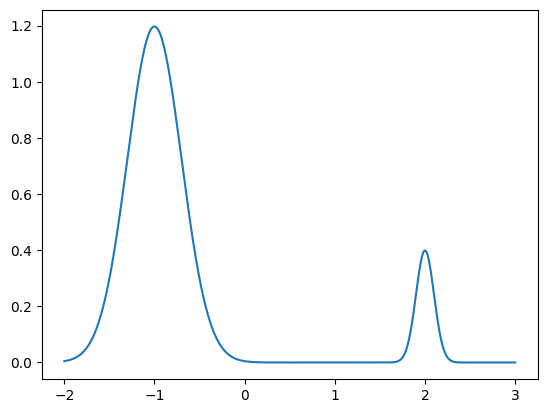

In [20]:
# Change the distribution function at the output layer

import matplotlib.pyplot as plt
tfd = tfp.distributions
x = np.linspace(-2., 3., int(1e4), dtype=np.float32)
gm = tfd.MixtureSameFamily(
  mixture_distribution=tfd.Categorical(
      probs=[0.9, 0.1]),
  components_distribution=tfd.Normal(
    loc=[-1., 2],       # One for each component.
    scale=[0.3, 0.1]))  # And same here.
plt.plot(x, gm.prob(x));

In [ ]:
# Preprocessing dataset

#Dat train[train['UL Throughput (Mbps)'] < -1] = -1 print(sum(train['UL Throughput (Mbps)'] == -1)) train['UL Throughput (Mbps)'].hist()

(-(+train['UL Throughput (Mbps)'])+1).apply(np.log2).hist()